# FCN vs CNN comparisons

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from comms import *
from training_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Training neural networks

In [2]:
class preamble_detector_cnn(nn.Module):
    def __init__(self, len_input=200):
        super(preamble_detector_cnn, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,35), 1)
        self.conv2 = nn.Conv2d(32, 32, (1,35), 1)

#         self.fc1 = nn.Linear(int((len_input-34)/2-34)*16, 128)
        self.fc1 = nn.Linear(int((len_input-34)-34)*32, 128)
        self.fc2 = nn.Linear(128, len_input)
#         self.fc3 = nn.Linear(64, len_input)

#         self.maxpool1 = nn.MaxPool2d(2)
#         self.maxpool2 = nn.MaxPool1d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
#         x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
#         x = self.fc3(x)
        
        x = x.squeeze()

        return x
    
class preamble_detector_fcn(nn.Module):
    def __init__(self):
        super(preamble_detector_fcn, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, (2,35), 1, padding=(0,17))
        self.conv2 = nn.Conv2d(32, 32, (1,35), 1, padding=(0,17))
        self.conv3 = nn.Conv2d(32, 1, (1,1), 1, padding=(0,0))

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = self.conv3(x).squeeze()

        return x

Special data generation function that allows specifying min/max time offsets.

In [3]:
def gen_training_data(preamble_seq, num_examples = 1024, payload= 128, signal_length = 200, snr = 10, add_phase_offset=True, gpu=True, 
                      labels_onehot=False, min_offset=0, max_offset=150, add_carrier_offset=True, max_cfo=1e4, sample_rate=1e6):

    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    # Pre-define array to contain complex-valued waveforms
    waveforms = np.zeros((num_examples,signal_length),dtype=np.complex128)

    # Predefine labels array
    labels = np.zeros((num_examples,),dtype=int)

    # Generate random payload bits
    bits = np.random.randint(0,2,(num_examples,payload))

    # Add preambles to payloads
    packets = np.concatenate((np.tile(preamble_seq,(num_examples,1)), bits), axis=1)

    # Map to BPSK symbols
    packets = np.where(packets < 1, -1+0j, 1+0j)

    # Insert into random offset and save offset as label
    for idx, waveform in enumerate(waveforms):
        offset = np.random.randint(min_offset, max_offset)
        if offset > (len(waveform) - payload- len(preamble)): #= 59
            waveform[offset:offset+len(packets[idx][:len(waveform) - (offset+payload+len(preamble))])] = packets[idx][:len(waveform) - (offset+payload+len(preamble))]
        else:
            waveform[offset:offset+payload+len(preamble)] = packets[idx]
           
        labels[idx] = offset
        
        # Add random phase offset
        if add_phase_offset:
            waveforms[idx] = phase_offset(waveform,offset=np.random.randint(-180,high=181))
        else:
            waveforms[idx] = waveform
        
        # Add random frequency offset up to max_cfo hz
        if add_carrier_offset:
            carrier_offset = np.random.randint(0, max_cfo)
            offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
            waveforms[idx] = offset_sine*waveforms[idx]

        # Normalize
        waveforms[idx] = waveforms[idx]/np.max(np.abs(waveforms[idx]))

    # Add noise
    waveforms = awgn(waveforms,snr)

    # Convert labels to pytorch tensors
    if labels_onehot:
        labels_oh = np.zeros((num_examples,signal_length))
        for idx, label in enumerate(labels):
            labels_oh[idx,label] = 1
        labels = torch.FloatTensor(labels_oh)
    else:
        labels = torch.LongTensor(labels)

    # Split into real and imaginary channels
    train_data = torch.FloatTensor(np.expand_dims(np.stack((waveforms.real, waveforms.imag),axis=1),axis=1))

    # Prep dataset for cuda if using gpu
    if gpu:
        train_data = train_data.cuda()
        labels = labels.cuda()
        
    return train_data, labels

In [20]:
def train_network(detector, optimizer, loss_fn, train_loader, val_loader, batch_size = 32, num_epochs=100):
    
    # Lists to hold losses
    losses, val_losses = [], []

    running_loss, running_val_loss = 0, 0
    
    best_loss = np.inf

    # Main training loop
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0

        # Loop over entire training loader
        for x_train, y_train in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = detector(x_train)
            loss = loss_fn(outputs, y_train)
            loss.backward()
            optimizer.step()

            # Add to running loss, average later
            running_loss = running_loss + loss.item()

        # Append average loss for this epoch to losses list
        losses.append(running_loss/len(train_loader))

        with torch.no_grad():
            # evaluate validation loss
            for x_val, y_val in val_loader:
                val_outputs = detector(x_val)
                val_loss = loss_fn(val_outputs, y_val)
                running_val_loss += val_loss.item()

        val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            saved_model = detector.state_dict()
            best_loss = val_losses[-1]
        
    # Load best model
    detector.load_state_dict(saved_model)
    
    return detector, losses, val_losses

In [21]:
preamble_seq = signal.max_len_seq(6)[0][:32]
preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

## Train CNN
Note that we're generating offsets only between 0 and 100. This is to showcase that a CNN can't generalize to untrained offsets, even though it has the capacity with 200 output neurons.

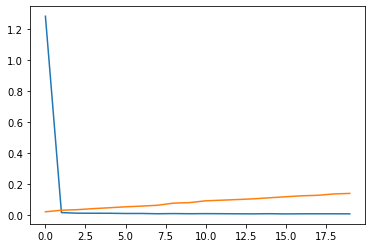

In [22]:
# training data
train_data, labels = gen_training_data(preamble_seq, num_examples = 8192*4, payload= 128, signal_length = 200, snr = 0, add_phase_offset=True, gpu=True,
                                       min_offset=0, max_offset=100, add_carrier_offset=True)
# train_data, labels = preprocess(train_data, labels, to_onehot=True)

train_dataset = torch.utils.data.TensorDataset(train_data, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# validation data
val_data, val_labels = gen_training_data(preamble_seq, num_examples = 256, payload= 128, signal_length = 200, snr = 0, add_phase_offset=True, gpu=True, 
                                         min_offset=0, max_offset=100, add_carrier_offset=True)
# val_data, val_labels = preprocess(val_data, val_labels, to_onehot=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

detector_cnn = preamble_detector_cnn(200)
detector_cnn.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(detector_cnn.parameters(), lr=0.001, weight_decay=0.001)

detector_cnn, losses, val_losses = train_network(detector_cnn, optimizer, loss_fn, train_loader, val_loader, 
                                                           num_epochs=20)


plt.plot(losses)
plt.plot(val_losses)

CNNs are good at overfitting (if you remove weight decay and reduce train size to 8192). Exporting this as a .svg to use as an example for overfitting.

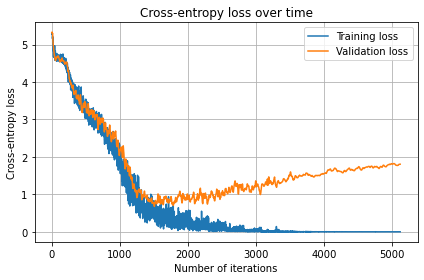

In [34]:
# plt.figure()
# plt.plot(losses)
# plt.plot(val_losses)
# plt.grid()
# plt.title('Cross-entropy loss over time')
# plt.xlabel('Number of iterations'); plt.ylabel('Cross-entropy loss')
# plt.legend(['Training loss', 'Validation loss'])
# plt.tight_layout()
# plt.savefig('early_stopping.svg', bbox_inches='tight', dpi=300)

## Train FCN

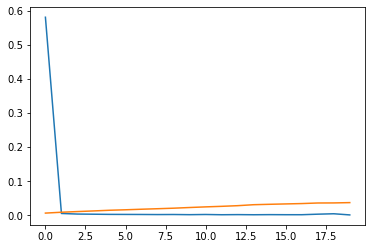

In [23]:
# training data
train_data, labels = gen_training_data(preamble_seq, num_examples = 8192, payload= 128, signal_length = 200, snr = 0, add_phase_offset=True, gpu=True,
                                       min_offset=0, max_offset=100, add_carrier_offset=True)

train_dataset = torch.utils.data.TensorDataset(train_data, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# validation data
val_data, val_labels = gen_training_data(preamble_seq, num_examples = 256, payload= 128, signal_length = 200, snr = 0, add_phase_offset=True, gpu=True, 
                                         min_offset=0, max_offset=100, add_carrier_offset=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

detector_fcn = preamble_detector_fcn()
detector_fcn.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(detector_fcn.parameters(), lr=0.001, weight_decay=0.001)

detector_fcn, losses, val_losses = train_network(detector_fcn, optimizer, loss_fn, train_loader, val_loader, 
                                                           num_epochs=20)


plt.plot(losses)
plt.plot(val_losses)

Let's compare a single frame prediction for correlation, CNN and FCN.

tensor(40)
tensor(40)


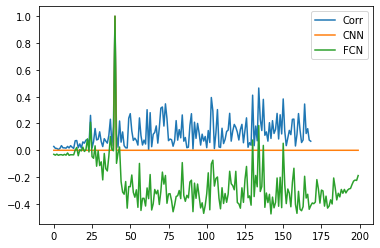

In [24]:
detector_cnn.cpu()
detector_fcn.cpu()

waveform = awgn(create_frame(preamble_seq),15)
my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

y_cnn = detector_cnn(my_frame)
y_fcn = detector_fcn(my_frame)
preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
correlation = np.abs(np.correlate(waveform, preamble, mode='valid'))
plt.plot(correlation/np.max(correlation))
plt.plot(torch.softmax(y_cnn,dim=0).detach().numpy()/np.max(torch.softmax(y_cnn,dim=0).detach().numpy()))
plt.plot(y_fcn.detach().numpy()/np.max(y_fcn.detach().numpy()))
plt.legend(('Corr','CNN','FCN'))
print(torch.argmax(y_cnn))
print(torch.argmax(y_fcn))

In [9]:
# Returns DER for given pytorch detector, make sure trained detector matches the
# preamble you are testing against
def test_detector(detector, preamble_seq, snr_range=None, num_iter=1500, payload=128, 
                  signal_length=200, add_phase_offset=True, normalize=True, carrier_offset=None,
                  max_offset=100):
    
    if snr_range is None:
        snr_range = np.arange(-10,15)

    nn_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/1e6)*np.arange(signal_length))
    
    for idx, snr in enumerate(snr_range):
        nn_err = float(0)
        for i in range(num_iter):
            
            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            # tau = np.random.randint(0, max_offset)
            
            my_frame = awgn(create_frame(preamble_seq, offset=tau),snr)
            
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine
            
            # normalize
            if normalize:
                my_frame = my_frame/np.max(np.abs(my_frame))
            
            my_frame = torch.FloatTensor(np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1)))
                
            nn_output = detector(my_frame)

            y_nn = torch.argmax(nn_output)

            # Calculate if error
            nn_err = nn_err + (y_nn != tau)

        nn_ers[idx] = nn_err

    nn_ders = nn_ers/num_iter
        
    return nn_ders

In [25]:
snr_range = np.arange(-10,15)

In [26]:
test_corr, test_ref = test_baselines(preamble_seq, snr_range = snr_range, num_iter=5000, payload=128)

In [27]:
nn_ders_cnn = test_detector(detector_cnn, preamble_seq, snr_range = snr_range, num_iter=500, payload=128, add_phase_offset=True, normalize=True)
nn_ders_fcn = test_detector(detector_fcn, preamble_seq, snr_range = snr_range, num_iter=500, payload=128, add_phase_offset=True, normalize=True)

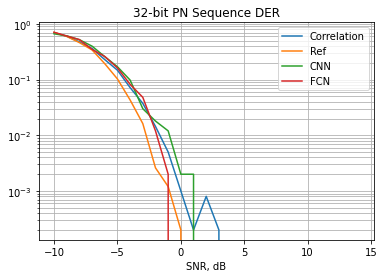

In [28]:
plt.semilogy(snr_range, test_corr)
plt.semilogy(snr_range, test_ref)
plt.semilogy(snr_range, nn_ders_cnn)
plt.semilogy(snr_range, nn_ders_fcn)
plt.title('32-bit PN Sequence DER')
plt.xlabel('SNR, dB')
plt.legend(('Correlation', 'Ref', 'CNN', 'FCN'))
# plt.legend(('FCN', 'CNN', 'Ref', 'Correlation'))
plt.grid(which='both')
# plt.ylim((0.0009))

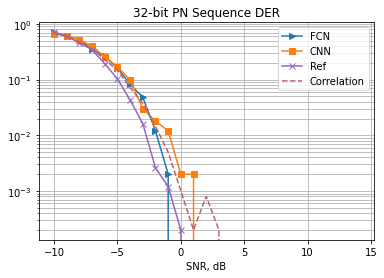

In [30]:
plt.semilogy(snr_range, nn_ders_fcn, '->', color='#1f77b4')
plt.semilogy(snr_range, nn_ders_cnn , '-s', color='#ff7f0e')
plt.semilogy(snr_range, test_ref, '-x', color='#9467bd')
plt.semilogy(snr_range, test_corr, '--', color='#bf616aff')
plt.title('32-bit PN Sequence DER')
plt.xlabel('SNR, dB')
# plt.legend(('Correlation', 'Ref', 'CNN', 'FCN'))
plt.legend(('FCN', 'CNN', 'Ref', 'Correlation'))
plt.grid(which='both')

In [31]:
cfos = np.arange(1,60)*1e3
ders_per_cfo_5 = []
ders_per_cfo_5_expert = []

for cfo in cfos:
    der, der_expert = test_baselines(preamble_seq, snr_range=[5], num_iter=5000, carrier_offset=cfo)
    ders_per_cfo_5.append(der)
    ders_per_cfo_5_expert.append(der_expert)

In [32]:
# cfos = np.arange(1,35)*1e3
fcn_ders_per_cfo_5 = []
cnn_ders_per_cfo_5 = []

for cfo in cfos:
    der_cnn = test_detector(detector_cnn, preamble_seq, num_iter=5000, payload=128, add_phase_offset=True, normalize=True, snr_range=[5], carrier_offset=cfo)
    der_fcn = test_detector(detector_fcn, preamble_seq, num_iter=5000, payload=128, add_phase_offset=True, normalize=True, snr_range=[5], carrier_offset=cfo)
#     der = test_detector(detector, signal.max_len_seq(6)[0][:32], num_iter=1500, snr_range=[0], carrier_offset=cfo)
    fcn_ders_per_cfo_5.append(der_fcn)
    cnn_ders_per_cfo_5.append(der_cnn)

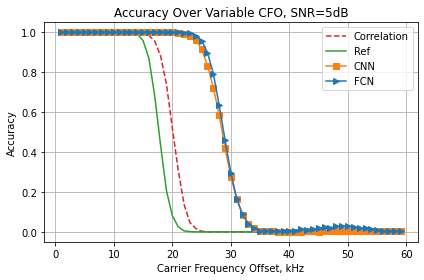

In [40]:

plt.plot(cfos/1e3, 1 - np.array(ders_per_cfo_5), 'C3--')#, color='#bf616aff')
plt.plot(cfos/1e3, 1 - np.array(ders_per_cfo_5_expert), 'C2')#, '-x', color='#9467bd')
plt.plot(cfos/1e3, 1 - np.array(cnn_ders_per_cfo_5), 'C1-s')#, color='#ff7f0e')
plt.plot(cfos/1e3, 1 - np.array(fcn_ders_per_cfo_5), 'C0->')#, color='#1f77b4')



plt.grid()
plt.title('Accuracy Over Variable CFO, SNR=5dB')
plt.xlabel('Carrier Frequency Offset, kHz')
plt.ylabel('Accuracy')
plt.legend(('Correlation', 'Ref', 'CNN', 'FCN'))
plt.tight_layout()
plt.savefig('figures/cfo_sensitivity_5.png', dpi=300, bbox_inches='tight')

## Confusion matrices

In [41]:
# make one frame of data with preamble attached with random time offset
def create_frame(preamble_seq, payload=128, signal_length=200, offset=40):
    waveform = np.zeros((signal_length,),dtype=np.complex128)
    bits = np.random.randint(0,2,payload)
    packet = np.concatenate((preamble_seq,bits))
    packet = np.where(packet < 1, -1+0j, 1+0j)
    if offset > (len(waveform) - payload- len(preamble)):
        waveform[offset:offset+len(packet[:len(waveform) - (offset+payload+len(preamble))])] = packet[:len(waveform) - (offset+payload+len(preamble))]
    else:
        waveform[offset:offset+payload+len(preamble_seq)] = packet
    
    return waveform

In [48]:
num_iter = 100

signal_length = 200
snr = 0
taus = np.arange(signal_length-len(preamble_seq))

cm_cnn = np.zeros((len(taus),signal_length))
cm_fcn = np.zeros((len(taus),signal_length))
cm_corr = np.zeros((len(taus),signal_length))

for tau in taus:
    nn_outputs_cnn = np.zeros((num_iter,signal_length))
    nn_outputs_fcn = np.zeros((num_iter,signal_length))
    corr_outputs = np.zeros((num_iter,signal_length))
    for i in range(num_iter):
        waveform = create_frame(preamble_seq, signal_length=signal_length, offset=tau)
        waveform = awgn(waveform,snr)
        my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

        nn_outputs_cnn[i,np.argmax(detector_cnn(my_frame).detach().numpy())] = 1
        nn_outputs_fcn[i,np.argmax(detector_fcn(my_frame).detach().numpy())] = 1
        corr_outputs[i,np.argmax(np.abs(np.correlate(waveform, preamble, mode='same')))] = 1
    
    cm_cnn[tau,:] = np.sum(nn_outputs_cnn,axis=0)
    cm_fcn[tau,:] = np.sum(nn_outputs_fcn,axis=0)
    cm_corr[tau,:] = np.sum(corr_outputs,axis=0)

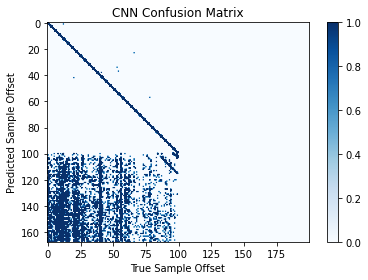

In [49]:
plt.figure()
plt.imshow(cm_cnn, cmap='Blues', vmin=0, vmax=1)
plt.title('CNN Confusion Matrix')
plt.xlabel('True Sample Offset')
plt.ylabel('Predicted Sample Offset')
plt.colorbar()
plt.tight_layout()
# plt.savefig('figures/cnn_confusion.png', dpi=300, bbox_inches='tight')

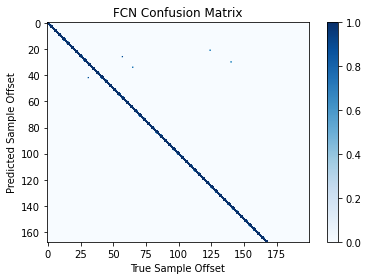

In [50]:
plt.figure()
plt.imshow(cm_fcn, cmap='Blues', vmin=0, vmax=1)
plt.title('FCN Confusion Matrix')
plt.xlabel('True Sample Offset')
plt.ylabel('Predicted Sample Offset')
plt.colorbar()
plt.tight_layout()
# plt.savefig('figures/fcn_confusion.png', dpi=300, bbox_inches='tight')

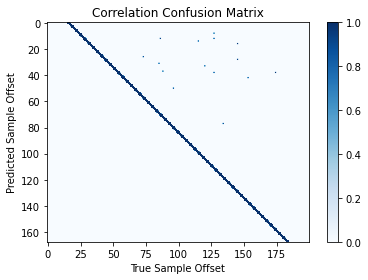

In [51]:
plt.figure()
plt.imshow(cm_corr, cmap='Blues', vmin=0, vmax=1)
plt.title('Correlation Confusion Matrix')
plt.xlabel('True Sample Offset')
plt.ylabel('Predicted Sample Offset')
plt.colorbar()
plt.tight_layout()
# plt.savefig('figures/corr_confusion.png', dpi=300, bbox_inches='tight')